In [3]:
import pandas as pd
import numpy as np
import pybaseball as pyb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, atan2, degrees, pi
from scipy.stats import percentileofscore
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

# This line ensures that the plots are displayed within the notebook
%matplotlib inline

pd.set_option('display.max_rows', None)

In [4]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query = """
SELECT 
    pe.PitcherId,
    pl.NamePlayer,
    pe.PitHand,
    p.x0,
    p.y0,
    p.z0,
    p.vx0,
    p.vy0,
    p.vz0,
    p.ax,
    p.ay,
    p.az,
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px,
    pl.NameParentTeam,
    v.URL
FROM 
    mlb_stats.dbo.pbp_play_event AS pe
LEFT JOIN 
    mlb_stats.dbo.pbp_play_event_pitch AS p
    ON p.GamePk = pe.GamePk 
    AND p.PlayId = pe.PlayId
LEFT JOIN 
    mlb_stats.dbo.pbp_game AS g
    ON g.GamePk = pe.GamePk
LEFT JOIN 
    mlb_stats.dbo.mlb_roster_status AS pl
    ON pl.PlayerID = pe.PitcherId
LEFT JOIN 
    mlb_stats.dbo.pbp_play_event_video AS v
    ON v.GamePk = pe.GamePk 
    AND v.PlayId = pe.PlayId
WHERE 
    pe.IsPitch = 1  
    AND p.PitchType = 'FA' 
    AND p.StartSpeed >= 80
    AND YEAR(g.GameDate) = 2024
    AND pl.NameParentTeam = 'Oakland Athletics'
    AND g.GameType = 'R'
	AND v.Source = 'BROADCAST'
"""

OAK_fastballs=pd.read_sql(query,cnxn) 

C:\Users\jreydel\AppData\Local\Temp\ipykernel_9344\3168884217.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  OAK_fastballs=pd.read_sql(query,cnxn)


In [5]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_complfb = """
SELECT [Name]
      ,[PlayerID]
      ,[Throws]
      ,[Level]
      ,[LeagueLevel]
      ,[Season]
      ,[SplitType]
      ,[PitchType]
      ,[TP]
      ,[Usage]
      ,[VeloAvg]
      ,[VeloMin]
      ,[VeloMax]
      ,[wAVG]
      ,[StrikeRate]
      ,[CalledStrikeRate]
      ,[InZone]
      ,[SwingRate]
      ,[Whiff]
      ,[InZoneWhiff]
      ,[OutZoneSwing]
      ,[HorzBreak]
      ,[VertIndBreak]
      ,[VAA]
      ,[Extension]
      ,[SpinRate]
      ,[SpinAxis]
      ,[SpinEff]
      ,[Tilt]
      ,[ReleaseX]
      ,[ReleaseZ]
      ,[ZValExp]
      ,[ZValObs]
      ,[StuffGrade]
      ,[StuffGradeSwing]
      ,[StuffPlus]
      ,[CommandPlus]
      ,[GBPer]
      ,[PUPer]
      ,[HitSpeedCt]
      ,[HitSpeed]
      ,[HitAngleV]
      ,[FirstGame]
      ,[LastGame]
      ,[UpdatedDate]
  FROM [mlb_stats].[dbo].[stat_pitcher_pitch]
  WHERE Season = 2024 AND PitchType = 'FA' AND SplitType = 'All' AND TP >= 75 AND CommandPlus IS NOT NULL
"""

OAK_Fastball_Command=pd.read_sql(query_complfb,cnxn) 

C:\Users\jreydel\AppData\Local\Temp\ipykernel_9344\3906776028.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  OAK_Fastball_Command=pd.read_sql(query_complfb,cnxn)


In [6]:
def calculate_vaa(row):
    yf = 17/12  # Home plate distance in feet, converted to inches
    ay = row['ay']  # Acceleration in y-dimension for the current pitch
    vy0 = row['vy0']  # Velocity in y-dimension at y=50 feet for the current pitch
    vz0 = row['vz0']  # Velocity in z-dimension at y=50 feet for the current pitch
    az = row['az']  # Acceleration in z-dimension for the current pitch

    vy_f = -sqrt(vy0**2 - (2 * ay * (50 - yf)))
    t = (vy_f - vy0) / ay
    vz_f = vz0 + (az * t)
    vaa_rad = atan2(vz_f, vy_f)
    vaa_deg = (180+degrees(vaa_rad))*-1

    return vaa_deg

In [7]:
def calculate_VRA(vy0, ay, release_extension, vz0, az):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vz_s = vz0 - az * t_s
    VRA = -np.arctan(vz_s / vy_s) * (180 / np.pi)
    return VRA

def calculate_HRA(vy0, ay, release_extension, vx0, ax):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vx_s = vx0 - ax * t_s
    HRA = -np.arctan(vx_s / vy_s) * (180 / np.pi)
    return HRA

In [8]:
OAK_fastballs['VAA'] = OAK_fastballs.apply(calculate_vaa, axis=1)

In [9]:
OAK_fastballs['VRA'] = OAK_fastballs.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
OAK_fastballs['HRA'] = OAK_fastballs.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)
pitch_count = OAK_fastballs['NamePlayer'].value_counts()

OAK_ff_filtered = OAK_fastballs[OAK_fastballs['NamePlayer'].isin(pitch_count.index[pitch_count >= 200])]
grouped_ff = OAK_ff_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_ff['VRA_percentile'] = 1 - grouped_ff['VRA'].rank(pct=True)
grouped_ff['HRA_percentile'] = 1 - grouped_ff['HRA'].rank(pct=True)
grouped_ff['release_pos_z_percentile'] = 1 - grouped_ff['ReleaseZ'].rank(pct=True)
grouped_ff['release_pos_x_percentile'] = 1 - grouped_ff['ReleaseX'].rank(pct=True)

grouped_ff['kirby_index'] = (
    grouped_ff['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_ff['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_ff['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_ff['release_pos_x_percentile'] * weights['ReleaseX']
)

OAK_ranked_pitchers_weighted_ff = grouped_ff.sort_values('kirby_index', ascending=False)

In [10]:
OAK_filtered_fastball_command = OAK_Fastball_Command.loc[:, ['PlayerID', 'StrikeRate', 'CalledStrikeRate', 'CommandPlus', 'InZone']]
OAK_full_fb_command = pd.merge(OAK_ranked_pitchers_weighted_ff, OAK_filtered_fastball_command, how='left', left_on='PitcherId', right_on='PlayerID')
OAK_full_fb_command_unique = OAK_full_fb_command.drop_duplicates(subset=['NamePlayer'])

from IPython.display import display

display(OAK_full_fb_command_unique)

NamePlayer  PitcherId       VRA       HRA  ReleaseX  ReleaseZ  \
0           Seth Elledge     676220  0.816205  0.765708  0.102768  0.086646   
1            Kyle Muller     666205  0.878693  0.619873  0.154640  0.100571   
2             Joey Estes     683155  0.821534  0.739546  0.178829  0.095612   
4         Brandon Bielak     656232  0.913251  0.733236  0.111064  0.099592   
5   Chen Zhong-Ao Zhuang     800018  0.801220  0.757043  0.200514  0.110309   
8         Ross Stripling     548389  0.946770  0.764299  0.127083  0.075494   
9           Colin Peluse     668761  0.951357  0.759309  0.121792  0.080189   
10        Domingo Robles     660781  0.891129  0.724831  0.189726  0.110101   
11          Mason Miller     695243  0.893727  0.761977  0.159681  0.100788   
12         Luis Carrasco     682918  0.810707  0.753903  0.220818  0.122898   
13         Robert Dugger     667498  0.837251  0.849553  0.170834  0.094421   
14         Gerson Moreno     642575  0.750512  0.936101  0.145045  0.091524   
15          Jack Cushing     681007  0.893685  0.777587  0.244320  0.094630   
17        Tyler Ferguson     621053  0.721213  0.872672  0.186269  0.111771   
19           Brady Basso     669620  0.984717  0.672665  0.178336  0.103184   
21       Jack O'Loughlin     672552  0.962798  0.814326  0.183023  0.086146   
23         Garrett Irvin     687868  1.041906  0.706441  0.141964  0.069805   
24          Osvaldo Bido     674370  0.923014  0.865693  0.140115  0.099296   
26              JP Sears     676664  0.921669  0.824866  0.121949  0.134251   
27          Grant Holman     680880  0.899692  0.878101  0.172978  0.093362   
29         Gerardo Reyes     622103  0.923097  0.827199  0.167864  0.110641   
30         Mason Barnett     686930  1.024230  0.735218  0.148374  0.100789   
31             J.T. Ginn     669372  0.956129  0.817882  0.160306  0.130936   
33        Colton Johnson     687439  0.971439  0.788061  0.187243  0.111312   
34          Aaron Brooks     605156  0.982443  0.835425  0.157071  0.099901   
36        Shohei Tomioka     693388  0.981936  0.835052  0.236443  0.081161   
37          Jack Perkins     678022  1.098508  0.739589  0.106830  0.091937   
38            Will Klein     694361  1.010023  0.701900  0.161185  0.139745   
39         Diego Barrera     685290  0.818737  0.867426  0.234253  0.199585   
41         Will Johnston     690658  1.024320  0.690324  0.276781  0.101698   
43          Hogan Harris     663687  0.883893  0.836952  0.278169  0.157880   
45     Steven Echavarria     806064  1.022411  0.814829  0.166253  0.101224   
46            Ryan Brown     688664  0.992464  0.813307  0.181720  0.123121   
47           Mitch Myers     688490  1.063059  0.724050  0.296230  0.088706   
48            Yunior Tur     814305  0.981775  0.773512  0.239810  0.132978   
49          Blaze Pontes     806281  1.002602  0.739881  0.205759  0.134866   
50        Gunnar Hoglund     680684  0.967857  0.842778  0.213659  0.131848   
51        Jackson Finley     686533  0.862338  0.890865  0.293387  0.145193   
52          Luis Morales     806960  0.996661  0.826764  0.280168  0.098859   
53       Stevie Emanuels     669434  1.077391  0.853915  0.153898  0.073905   
54           Luis Medina     665622  0.984473  0.824613  0.211354  0.142500   
55            Dylan Hall     689876  0.957226  0.915502  0.466967  0.087083   
56           Ryan Cusick     680743  0.951003  0.932823  0.167481  0.141083   
57        Hunter Breault     676292  1.037531  0.766086  0.218016  0.121793   
58         Michael Kelly     547184  0.948073  0.893816  0.283142  0.122412   
59          Tzu-Chen Sha     809223  1.026364  0.753367  0.221369  0.177594   
60           Blake Beers     676275  0.994604  0.891310  0.255321  0.097157   
61           Chase Cohen     681484  1.103554  0.686727  0.240889  0.166286   
62          Austin Adams     613534  0.897136  0.995875  0.329210  0.156614   
63         Grant Judkins     680420  1.028827  0.857916  0.44573

In [11]:
OAK_select = OAK_full_fb_command_unique.loc[:, ['NamePlayer', 'StrikeRate', 'InZone', 'CommandPlus', 'kirby_index']]
display(OAK_select)

NamePlayer  StrikeRate    InZone  CommandPlus  kirby_index
0           Seth Elledge    0.692529  0.522989           50     0.862121
1            Kyle Muller    0.752161  0.610951           55     0.847576
2             Joey Estes    0.675556  0.413333           50     0.813788
4         Brandon Bielak    0.648649  0.470270           50     0.790455
5   Chen Zhong-Ao Zhuang    0.734375  0.621094           75     0.765303
8         Ross Stripling    0.628895  0.422096           65     0.764091
9           Colin Peluse    0.653614  0.521084           50     0.754848
10        Domingo Robles    0.697674  0.542636           55     0.751667
11          Mason Miller    0.700980  0.526961           35     0.741667
12         Luis Carrasco    0.625000  0.429688           45     0.727576
13         Robert Dugger    0.611898  0.498584           50     0.700303
14         Gerson Moreno    0.632743  0.453540           40     0.683636
15          Jack Cushing    0.694853  0.514706           55     0.671970
17        Tyler Ferguson    0.717391  0.507246           55     0.651970
19           Brady Basso    0.725962  0.567308           60     0.650303
21       Jack O'Loughlin    0.605372  0.487603           35     0.645152
23         Garrett Irvin    0.700965  0.581994           60     0.631364
24          Osvaldo Bido    0.630952  0.484127           40     0.628636
26              JP Sears    0.642857  0.478992           55     0.615152
27          Grant Holman    0.648515  0.485149           45     0.613030
29         Gerardo Reyes    0.656676  0.471390           35     0.608333
30         Mason Barnett    0.649451  0.482418           40     0.583030
31             J.T. Ginn    0.564706  0.341176           40     0.573030
33        Colton Johnson    0.647668  0.414508           50     0.564242
34          Aaron Brooks    0.562500  0.359375           55     0.558485
36        Shohei Tomioka    0.634409  0.518280           45     0.549091
37          Jack Perkins    0.632153  0.446866           45     0.540000
38            Will Klein    0.615752  0.436754           40     0.538030
39         Diego Barrera    0.722892  0.578313           70     0.517727
41         Will Johnston    0.623932  0.538462           55     0.513182
43          Hogan Harris    0.620952  0.476190           30     0.512273
45     Steven Echavarria    0.625330  0.437995           40     0.498333
46            Ryan Brown    0.707885  0.532258           55     0.497576
47           Mitch Myers    0.649351  0.472403           65     0.492121
48            Yunior Tur    0.656121  0.537827           55     0.492121
49          Blaze Pontes    0.625407  0.456026           50     0.484697
50        Gunnar Hoglund    0.648681  0.516787           50     0.471667
51        Jackson Finley    0.672884  0.581062           50     0.466515
52          Luis Morales    0.633694  0.502318           40     0.455455
53       Stevie Emanuels    0.539474  0.401316           30     0.443333
54           Luis Medina    0.636667  0.526667           60     0.442576
55            Dylan Hall    0.694611  0.520958           50     0.436667
56           Ryan Cusick    0.608602  0.496774           35     0.426818
57        Hunter Breault    0.642857  0.500000           55     0.419697
58         Michael Kelly    0.593333  0.413333           35     0.415909
59          Tzu-Chen Sha    0.691252  0.569468           50     0.397121
60           Blake Beers    0.613139  0.445255           45     0.386970
61           Chase Cohen    0.648760  0.537190           50     0.357576
62          Austin Adams    0.590164  0.480874           40     0.355758
63         Grant Judkins    0.613139  0.458029           60     0.352424
64          Dany Jiménez    0.601351  0.493243           55     0.351970
65          Danis Correa    0.662420  0.496815           55     0.328030
67         Michel Otañez    0.634868  0.467105           40     0.318636
69          Zach Jackson    0.461224  0.322449           20     0.300606

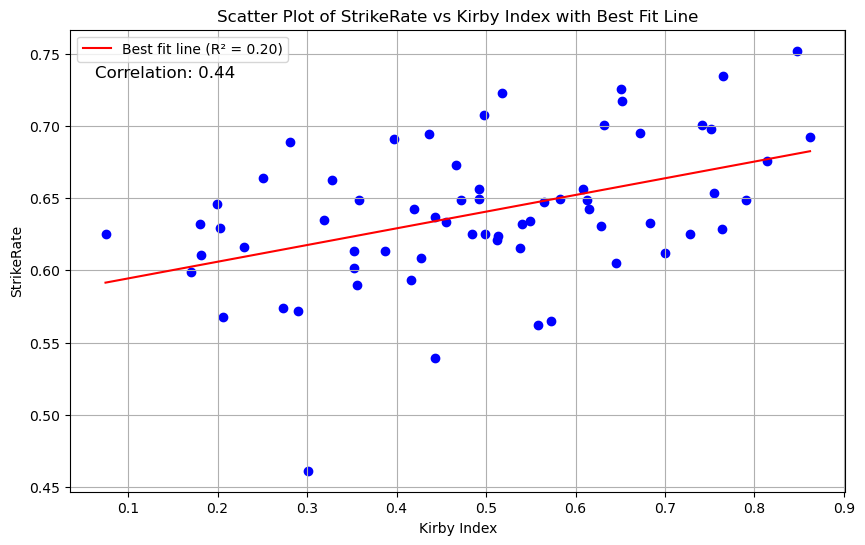

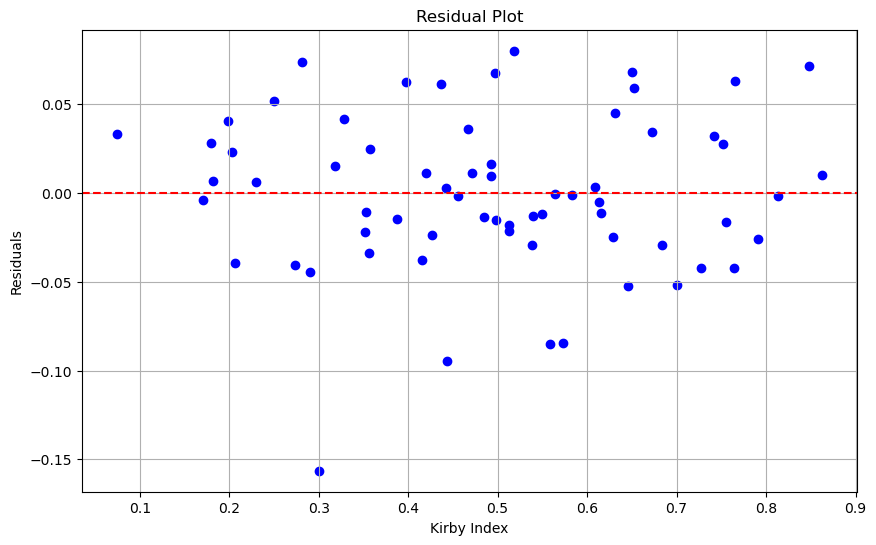

kirby_index    InZone  Residual
0      0.862121  0.692529  0.009972
1      0.847576  0.752161  0.071287
2      0.813788  0.675556 -0.001412
4      0.790455  0.648649 -0.025621
5      0.765303  0.734375  0.063013
8      0.764091  0.628895 -0.042326
9      0.754848  0.653614 -0.016539
10     0.751667  0.697674  0.027889
11     0.741667  0.700980  0.032352
12     0.727576  0.625000 -0.042000
13     0.700303  0.611898 -0.051948
14     0.683636  0.632743 -0.029176
15     0.671970  0.694853  0.034283
17     0.651970  0.717391  0.059134
19     0.650303  0.725962  0.067897
21     0.645152  0.605372 -0.052097
23     0.631364  0.700965  0.045090
24     0.628636  0.630952 -0.024607
26     0.615152  0.642857 -0.011143
27     0.613030  0.648515 -0.005240
29     0.608333  0.656676  0.003464
30     0.583030  0.649451 -0.000836
31     0.573030  0.564706 -0.084424
33     0.564242  0.647668 -0.000445
34     0.558485  0.562500 -0.084948
36     0.549091  0.634409 -0.011953
37     0.540000  0.632153 -0.013158
38     0.538030  0.615752 -0.029331
39     0.517727  0.722892  0.080156
41     0.513182  0.623932 -0.018278
43     0.512273  0.620952 -0.021152
45     0.498333  0.625330 -0.015163
46     0.497576  0.707885  0.067480
47     0.492121  0.649351  0.009576
48     0.492121  0.656121  0.016346
49     0.484697  0.625407 -0.013509
50     0.471667  0.648681  0.011272
51     0.466515  0.672884  0.036070
52     0.455455  0.633694 -0.001841
53     0.443333  0.539474 -0.094660
54     0.442576  0.636667  0.002621
55     0.436667  0.694611  0.061248
56     0.426818  0.608602 -0.023622
57     0.419697  0.642857  0.011457
58     0.415909  0.593333 -0.037629
59     0.397121  0.691252  0.062462
60     0.386970  0.613139 -0.014477
61     0.357576  0.648760  0.024543
62     0.355758  0.590164 -0.033843
63     0.352424  0.613139 -0.010483
64     0.351970  0.601351 -0.022218
65     0.328030  0.662420  0.041619
67     0.318636  0.634868  0.015153
69     0.300606  0.461224 -0.156406
70     0.290152  0.571809 -0.044613
71     0.281212  0.689024  0.073637
73     0.273182  0.574194 -0.040266
75     0.250303  0.663717  0.051903
76     0.230000  0.615909  0.006443
77     0.206515  0.567442 -0.039309
79     0.202727  0.629699  0.023387
80     0.198788  0.646226  0.040369
81     0.181515  0.610548  0.006688
83     0.180000  0.631799  0.028114
85     0.170303  0.598820 -0.003744
87     0.074697  0.625000  0.033491

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

%matplotlib inline

# Ensure the merged DataFrame has the required columns
if 'StrikeRate' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['StrikeRate']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

     # Calculate residuals
    residuals = y - line

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of StrikeRate vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('StrikeRate')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()
      
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)
else:
    print("Required columns 'StrikeRate' and 'kirby_index' are not present in the DataFrame.")

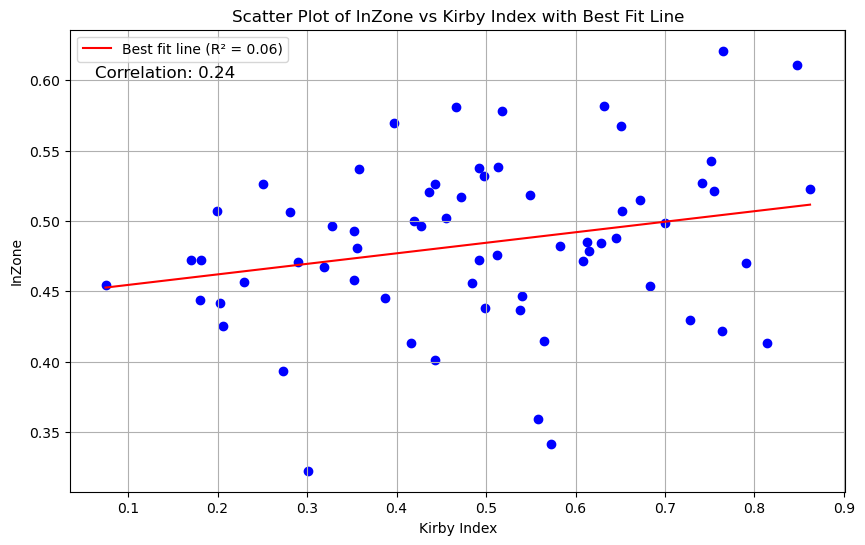

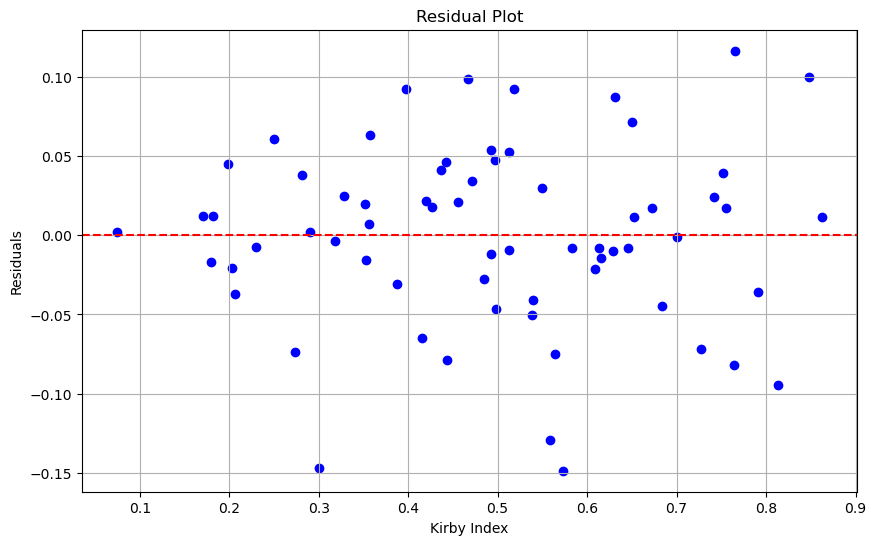

kirby_index    InZone  Residual
0      0.862121  0.522989  0.011345
1      0.847576  0.610951  0.100397
2      0.813788  0.413333 -0.094690
4      0.790455  0.470270 -0.036006
5      0.765303  0.621094  0.116701
8      0.764091  0.422096 -0.082205
9      0.754848  0.521084  0.017475
10     0.751667  0.542636  0.039265
11     0.741667  0.526961  0.024339
12     0.727576  0.429688 -0.071879
13     0.700303  0.498584 -0.000941
14     0.683636  0.453540 -0.044736
15     0.671970  0.514706  0.017304
17     0.651970  0.507246  0.011342
19     0.650303  0.567308  0.071528
21     0.645152  0.487603 -0.007790
23     0.631364  0.581994  0.087633
24     0.628636  0.484127 -0.010030
26     0.615152  0.478992 -0.014155
27     0.613030  0.485149 -0.007839
29     0.608333  0.471390 -0.021246
30     0.583030  0.482418 -0.008323
31     0.573030  0.341176 -0.148816
33     0.564242  0.414508 -0.074826
34     0.558485  0.359375 -0.129528
36     0.549091  0.518280  0.030081
37     0.540000  0.446866 -0.040652
38     0.538030  0.436754 -0.050616
39     0.517727  0.578313  0.092463
41     0.513182  0.538462  0.052952
43     0.512273  0.476190 -0.009251
45     0.498333  0.437995 -0.046403
46     0.497576  0.532258  0.047917
47     0.492121  0.472403 -0.011530
48     0.492121  0.537827  0.053894
49     0.484697  0.456026 -0.027350
50     0.471667  0.516787  0.034386
51     0.466515  0.581062  0.099047
52     0.455455  0.502318  0.021132
53     0.443333  0.401316 -0.078963
54     0.442576  0.526667  0.046445
55     0.436667  0.520958  0.041179
56     0.426818  0.496774  0.017733
57     0.419697  0.500000  0.021492
58     0.415909  0.413333 -0.064891
59     0.397121  0.569468  0.092651
60     0.386970  0.445255 -0.030802
61     0.357576  0.537190  0.063335
62     0.355758  0.480874  0.007155
63     0.352424  0.458029 -0.015441
64     0.351970  0.493243  0.019808
65     0.328030  0.496815  0.025173
67     0.318636  0.467105 -0.003834
69     0.300606  0.322449 -0.147140
70     0.290152  0.470745  0.001939
71     0.281212  0.506098  0.037961
73     0.273182  0.393548 -0.073986
75     0.250303  0.526549  0.060727
76     0.230000  0.456818 -0.007483
77     0.206515  0.425581 -0.036960
79     0.202727  0.441729 -0.020529
80     0.198788  0.507075  0.045112
81     0.181515  0.472617  0.011947
83     0.180000  0.443515 -0.017041
85     0.170303  0.471976  0.012147
87     0.074697  0.454545  0.001876

In [31]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Ensure the merged DataFrame has the required columns
if 'StrikeRate' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['InZone']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

     # Calculate residuals
    residuals = y - line

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of InZone vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('InZone')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()
      
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)
else:
    print("Required columns 'StrikeRate' and 'kirby_index' are not present in the DataFrame.")

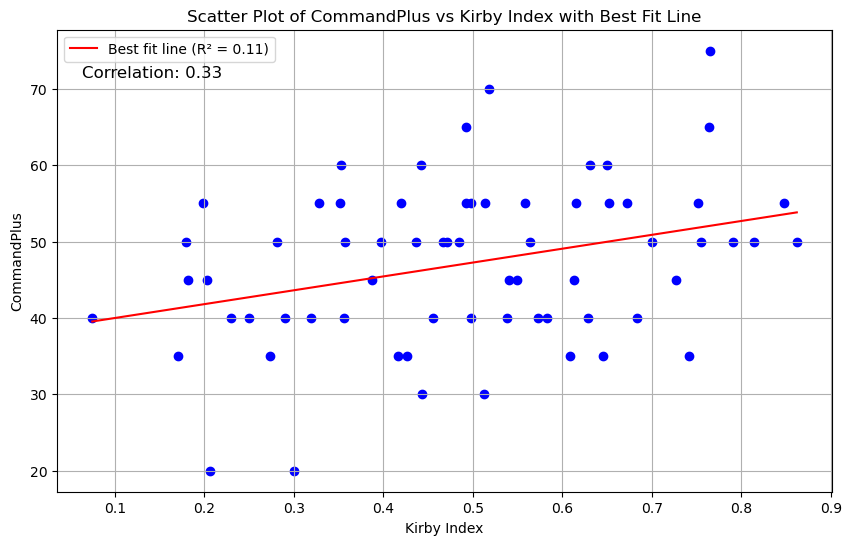

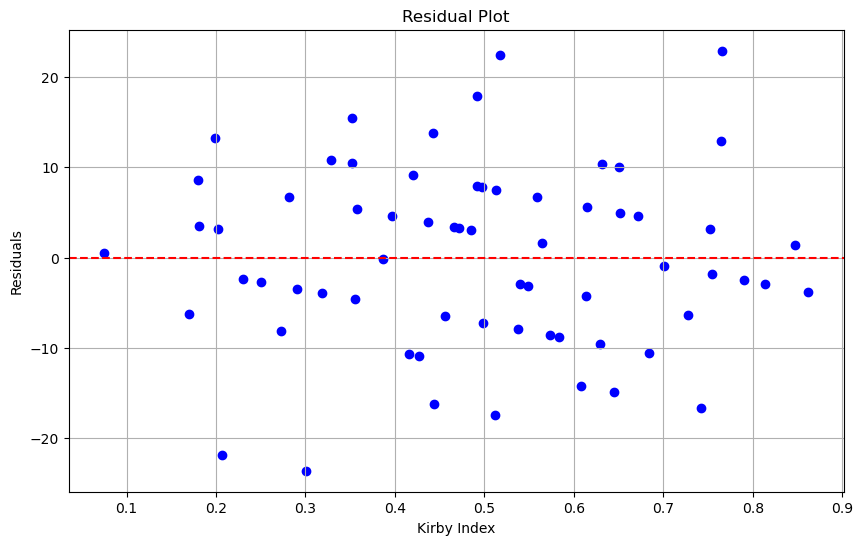

kirby_index  InZone   Residual
0      0.862121      50  -3.830301
1      0.847576      55   1.433664
2      0.813788      50  -2.953170
4      0.790455      50  -2.529727
5      0.765303      75  22.926711
8      0.764091      65  12.948708
9      0.754848      50  -1.883565
10     0.751667      55   3.174177
11     0.741667      35 -16.644348
12     0.727576      45  -6.388632
13     0.700303      50  -0.893700
14     0.683636      40 -10.591241
15     0.671970      55   4.620481
17     0.651970      55   4.983431
19     0.650303      60  10.013677
21     0.645152      35 -14.892836
23     0.631364      60  10.357380
24     0.628636      40  -9.593126
26     0.615152      55   5.651590
27     0.613030      45  -4.309915
29     0.608333      35 -14.224676
30     0.583030      40  -8.765489
31     0.573030      40  -8.584013
33     0.564242      50   1.575465
34     0.558485      55   6.679951
36     0.549091      45  -3.149572
37     0.540000      45  -2.984595
38     0.538030      40  -7.948850
39     0.517727      70  22.419600
41     0.513182      55   7.502089
43     0.512273      30 -17.481413
45     0.498333      40  -7.228448
46     0.497576      55   7.785301
47     0.492121      65  17.884287
48     0.492121      55   7.884287
49     0.484697      50   3.019019
50     0.471667      50   3.255487
51     0.466515      50   3.348974
52     0.455455      40  -6.450303
53     0.443333      30 -16.230333
54     0.442576      60  13.783415
55     0.436667      50   3.890650
56     0.426818      35 -10.930624
57     0.419697      55   9.198609
58     0.415909      35 -10.732651
59     0.397121      50   4.608303
60     0.386970      45  -0.207472
61     0.357576      50   5.325955
62     0.355758      40  -4.641049
63     0.352424      60  15.419443
64     0.351970      55  10.427692
65     0.328030      55  10.862133
67     0.318636      40  -3.967391
69     0.300606      20 -23.640185
70     0.290152      40  -3.450461
71     0.281212      50   6.711767
73     0.273182      35  -8.142503
75     0.250303      40  -2.727309
76     0.230000      40  -2.358859
77     0.206515      20 -21.932667
79     0.202727      45   3.136074
80     0.198788      55  13.207564
81     0.181515      45   3.521021
83     0.180000      50   8.548518
85     0.170303      35  -6.275506
87     0.074697      40   0.459508

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Ensure the merged DataFrame has the required columns
if 'StrikeRate' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['CommandPlus']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

     # Calculate residuals
    residuals = y - line

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of CommandPlus vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('CommandPlus')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()
     
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)
else:
    print("Required columns 'StrikeRate' and 'kirby_index' are not present in the DataFrame.")

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a m

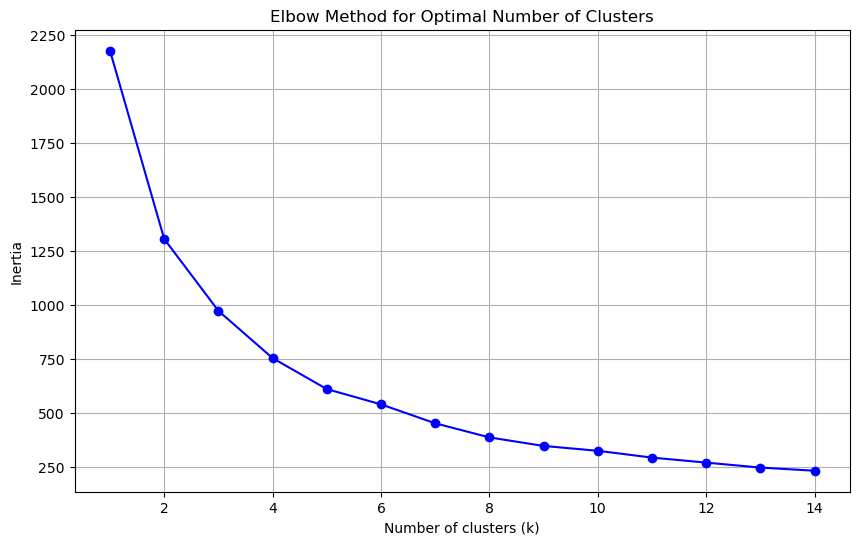

In [41]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import mplcursors

# Filter for player fastballs
OAK_ff_player_HRA_VRA_CL = OAK_ff_filtered[OAK_ff_filtered['NamePlayer'] == 'James Gonzalez']

# Ensure there are no missing values in 'HRA' and 'VRA' columns
OAK_ff_player_HRA_VRA_CL = OAK_ff_player_HRA_VRA_CL.dropna(subset=['HRA', 'VRA'])

# Prepare the data for clustering
X = OAK_ff_player_HRA_VRA_CL[['HRA', 'VRA']]

# Perform K-means clustering for a range of cluster numbers and calculate inertia
inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow method result
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



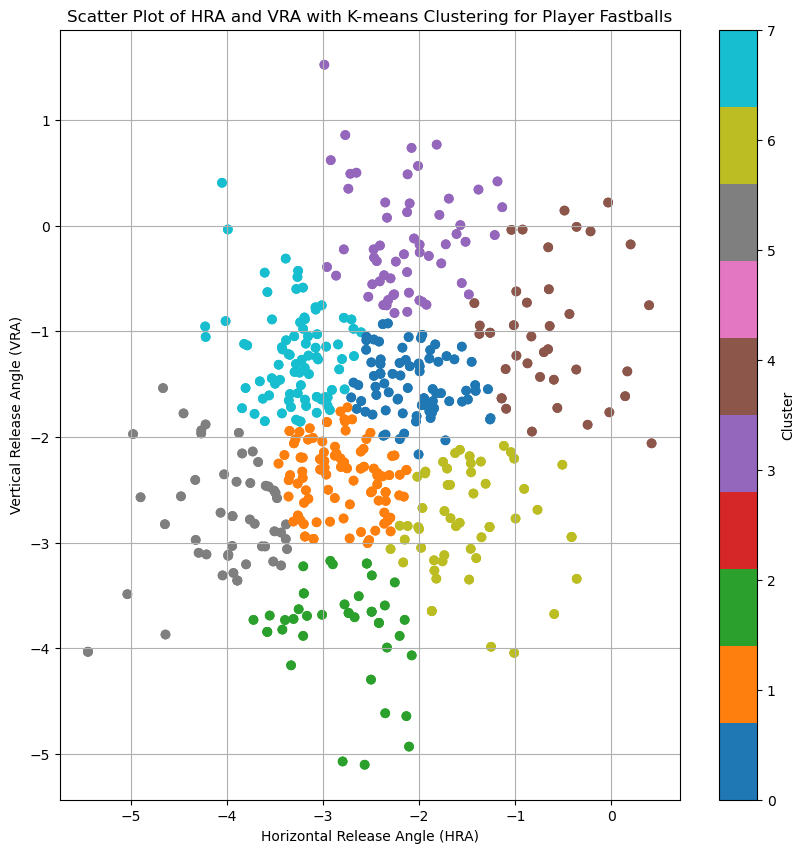

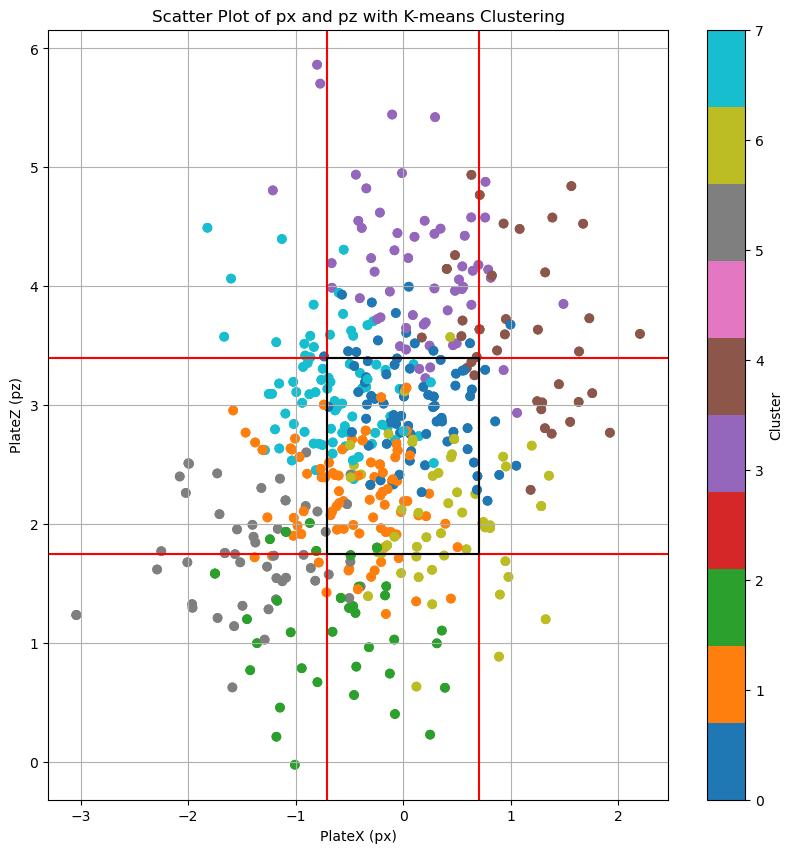

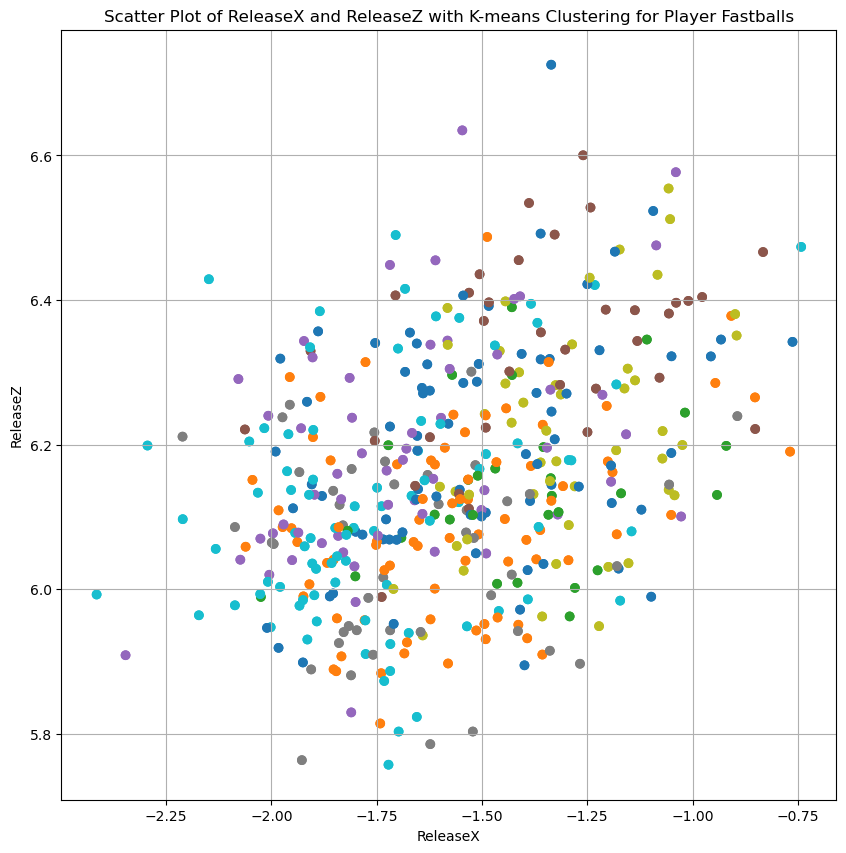

In [43]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=8, random_state=4).fit(X)
OAK_ff_player_HRA_VRA_CL['cluster'] = kmeans.labels_

# Scatter plot for HRA and VRA
fig1, ax1 = plt.subplots(figsize=(10, 10))
sc1 = ax1.scatter(OAK_ff_player_HRA_VRA_CL['HRA'], OAK_ff_player_HRA_VRA_CL['VRA'], 
                  c=OAK_ff_player_HRA_VRA_CL['cluster'], cmap='tab10', marker='o')
ax1.set_title('Scatter Plot of HRA and VRA with K-means Clustering for Player Fastballs')
ax1.set_xlabel('Horizontal Release Angle (HRA)')
ax1.set_ylabel('Vertical Release Angle (VRA)')
ax1.grid(True)
plt.colorbar(sc1, ax=ax1, label='Cluster')

# Add cursor functionality
cursor1 = mplcursors.cursor(sc1, hover=True)
@cursor1.connect("add")
def on_add1(sel):
    index = sel.target.index
    sel.annotation.set_text(f"URL: {OAK_ff_player_HRA_VRA_CL.iloc[index]['URL']}")

plt.show()

# Scatter plot for px and pz
fig2, ax2 = plt.subplots(figsize=(10, 10))
sc2 = ax2.scatter(OAK_ff_player_HRA_VRA_CL['px'], OAK_ff_player_HRA_VRA_CL['pz'], 
                  c=OAK_ff_player_HRA_VRA_CL['cluster'], cmap='tab10', marker='o')
ax2.set_title('Scatter Plot of px and pz with K-means Clustering')
ax2.set_xlabel('PlateX (px)')
ax2.set_ylabel('PlateZ (pz)')
ax2.grid(True)
plt.colorbar(sc2, ax=ax2, label='Cluster')
ax2.axvline(x=0.7083, color='r', linestyle='-')
ax2.axvline(x=-0.7083, color='r', linestyle='-')
ax2.axhline(y=1.75, color='r', linestyle='-')
ax2.axhline(y=3.4, color='r', linestyle='-')

# Add the box
ax2.plot([-0.7083, 0.7083], [1.75, 1.75], color='black')
ax2.plot([-0.7083, 0.7083], [3.4, 3.4], color='black')
ax2.plot([-0.7083, -0.7083], [1.75, 3.4], color='black')
ax2.plot([0.7083, 0.7083], [1.75, 3.4], color='black')

# Add cursor functionality
cursor2 = mplcursors.cursor(sc2, hover=True)
@cursor2.connect("add")
def on_add2(sel):
    index = sel.target.index
    sel.annotation.set_text(f"URL: {OAK_ff_player_HRA_VRA_CL.iloc[index]['URL']}")


plt.show()


fig3, ax3 = plt.subplots(figsize=(10, 10))
sc3 = ax3.scatter(OAK_ff_player_HRA_VRA_CL['ReleaseX'], OAK_ff_player_HRA_VRA_CL['ReleaseZ'], 
                  c=OAK_ff_player_HRA_VRA_CL['cluster'], cmap='tab10', marker='o')
ax3.set_title('Scatter Plot of ReleaseX and ReleaseZ with K-means Clustering for Player Fastballs')
ax3.set_xlabel('ReleaseX')
ax3.set_ylabel('ReleaseZ')
ax3.grid(True)
plt.colorbar(sc1, ax=ax1, label='Cluster')

# Add cursor functionality
cursor3 = mplcursors.cursor(sc1, hover=True)
@cursor3.connect("add")
def on_add1(sel):
    index = sel.target.index
    sel.annotation.set_text(f"URL: {OAK_ff_player_HRA_VRA_CL.iloc[index]['URL']}")

plt.show()

In [28]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from sklearn.cluster import KMeans
import pandas as pd


# Filter for player fastballs
OAK_ff_player_HRA_VRA_CL = OAK_ff_filtered[OAK_ff_filtered['NamePlayer'] == 'James Gonzalez']

# Ensure there are no missing values in 'HRA' and 'VRA' columns
OAK_ff_player_HRA_VRA_CL = OAK_ff_player_HRA_VRA_CL.dropna(subset=['HRA', 'VRA'])

# Prepare the data for clustering
X = OAK_ff_player_HRA_VRA_CL[['HRA', 'VRA']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=8, random_state=4).fit(X)
OAK_ff_player_HRA_VRA_CL['cluster'] = kmeans.labels_

# Create the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Graph(id='scatter-hra-vra'),
    dcc.Graph(id='scatter-px-pz'),
    dcc.Location(id='url', refresh=True)
])

# Callback to update the scatter plot for HRA and VRA
@app.callback(
    Output('scatter-hra-vra', 'figure'),
    Input('scatter-hra-vra', 'clickData')
)
def update_hra_vra(clickData):
    fig1 = px.scatter(OAK_ff_player_HRA_VRA_CL, x='HRA', y='VRA', color='cluster',
                      title='Scatter Plot of HRA and VRA with K-means Clustering for Player Fastballs',
                      labels={'HRA': 'Horizontal Release Angle (HRA)', 'VRA': 'Vertical Release Angle (VRA)'},
                      hover_data=['URL'])
    fig1.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig1.update_traces(marker=dict(size=10))
    return fig1

# Callback to update the scatter plot for px and pz
@app.callback(
    Output('scatter-px-pz', 'figure'),
    Input('scatter-px-pz', 'clickData')
)
def update_px_pz(clickData):
    fig2 = px.scatter(OAK_ff_player_HRA_VRA_CL, x='px', y='pz', color='cluster',
                      title='Scatter Plot of px and pz with K-means Clustering',
                      labels={'px': 'PlateX (px)', 'pz': 'PlateZ (pz)'},
                      hover_data=['URL'])
    fig2.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig2.update_traces(marker=dict(size=10))
    
    fig2.add_shape(type='line', x0=0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=-0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=1.75, y1=1.75, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=3.4, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='rect', x0=-0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Black'))
    
    return fig2

# Callback to handle URL redirection for both graphs
@app.callback(
    Output('url', 'href'),
    [Input('scatter-hra-vra', 'clickData'),
     Input('scatter-px-pz', 'clickData')]
)
def redirect_url(clickDataHraVra, clickDataPxPz):
    context = dash.callback_context

    if not context.triggered:
        return dash.no_update

    triggered_id = context.triggered[0]['prop_id'].split('.')[0]

    if triggered_id == 'scatter-hra-vra' and clickDataHraVra:
        point_index = clickDataHraVra['points'][0]['pointIndex']
        url = OAK_ff_player_HRA_VRA_CL.iloc[point_index]['URL']
        return url
    elif triggered_id == 'scatter-px-pz' and clickDataPxPz:
        point_index = clickDataPxPz['points'][0]['pointIndex']
        url = OAK_ff_player_HRA_VRA_CL.iloc[point_index]['URL']
        return url
    return dash.no_update

# Open a web browser tab with the app URL
def open_browser():
    import webbrowser
    webbrowser.open_new_tab("http://127.0.0.1:8063/")

# Run the app
if __name__ == '__main__':
    open_browser()
    app.run_server(debug=True, port=8063)


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



In [18]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query = """

SELECT 
    pe.PitcherId,

    pl.NamePlayer,
    pe.PitHand,
    p.x0,
    p.y0,
    p.z0,
    p.vx0,
    p.vy0,
    p.vz0,
    p.ax,
    p.ay,
    p.az,
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px,
    pl.NameParentTeam,
	g.AwayTeamId,
    v.URL
FROM 
    mlb_stats.dbo.pbp_play_event AS pe
LEFT JOIN 
    mlb_stats.dbo.pbp_play_event_pitch AS p
    ON p.GamePk = pe.GamePk 
    AND p.PlayId = pe.PlayId
LEFT JOIN 
    mlb_stats.dbo.pbp_game AS g
    ON g.GamePk = pe.GamePk
LEFT JOIN 
    mlb_stats.dbo.mlb_roster_status AS pl
    ON pl.PlayerID = pe.PitcherId
LEFT JOIN 
    mlb_stats.dbo.pbp_play_event_video AS v
    ON v.GamePk = pe.GamePk 
    AND v.PlayId = pe.PlayId
WHERE 
    pe.IsPitch = 1  
    AND p.PitchType = 'FA' 
    AND p.StartSpeed >= 80
    AND g.GameDate = '2024-07-22'
    AND g.GamePk = 745635
    AND g.AwayTeamId = 117
    AND pl.NameParentTeam = 'Oakland Athletics'
    AND g.GameType = 'R'
	AND v.Source = 'BROADCAST'
"""

Day_of_fastballs=pd.read_sql(query,cnxn) 

C:\Users\jreydel\AppData\Local\Temp\ipykernel_9344\2150079120.py:70: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [19]:
Day_of_fastballs['VRA'] = Day_of_fastballs.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
Day_of_fastballs['HRA'] = Day_of_fastballs.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)


In [20]:

pitch_count = Day_of_fastballs['NamePlayer'].value_counts()

Day_of_fastballs_filtered = Day_of_fastballs[Day_of_fastballs['NamePlayer'].isin(pitch_count.index[pitch_count >= 10])]



In [21]:

Day_of_grouped_ff = Day_of_fastballs_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

Day_of_grouped_ff['VRA_percentile'] = 1 - Day_of_grouped_ff['VRA'].rank(pct=True)
Day_of_grouped_ff['HRA_percentile'] = 1 - Day_of_grouped_ff['HRA'].rank(pct=True)
Day_of_grouped_ff['release_pos_z_percentile'] = 1 - Day_of_grouped_ff['ReleaseZ'].rank(pct=True)
Day_of_grouped_ff['release_pos_x_percentile'] = 1 - Day_of_grouped_ff['ReleaseX'].rank(pct=True)

Day_of_grouped_ff['kirby_index'] = (
    Day_of_grouped_ff['VRA_percentile'] * weights['VRA_degrees'] +
    Day_of_grouped_ff['HRA_percentile'] * weights['HRA_degrees'] +
    Day_of_grouped_ff['release_pos_z_percentile'] * weights['ReleaseZ'] +
    Day_of_grouped_ff['release_pos_x_percentile'] * weights['ReleaseX']
)

Day_of_ranked_pitchers_weighted_ff = Day_of_grouped_ff.sort_values('kirby_index', ascending=False)

In [22]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from sklearn.cluster import KMeans
import pandas as pd


# Filter for player fastballs
Day_of_player_HRA_VRA_CL = Day_of_fastballs_filtered[Day_of_fastballs_filtered['NamePlayer'] == 'Hogan Harris']

# Ensure there are no missing values in 'HRA' and 'VRA' columns
Day_of_player_HRA_VRA_CL = Day_of_player_HRA_VRA_CL.dropna(subset=['HRA', 'VRA'])

# Prepare the data for clustering
X = Day_of_player_HRA_VRA_CL[['HRA', 'VRA']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=8, random_state=4).fit(X)
Day_of_player_HRA_VRA_CL['cluster'] = kmeans.labels_

# Create the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Graph(id='scatter-hra-vra'),
    dcc.Graph(id='scatter-px-pz'),
    dcc.Location(id='url', refresh=True)
])

# Callback to update the scatter plot for HRA and VRA
@app.callback(
    Output('scatter-hra-vra', 'figure'),
    Input('scatter-hra-vra', 'clickData')
)
def update_hra_vra(clickData):
    fig1 = px.scatter(Day_of_player_HRA_VRA_CL, x='HRA', y='VRA', color='cluster',
                      title='Scatter Plot of HRA and VRA with K-means Clustering for Player Fastballs',
                      labels={'HRA': 'Horizontal Release Angle (HRA)', 'VRA': 'Vertical Release Angle (VRA)'},
                      hover_data=['URL'])
    fig1.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig1.update_traces(marker=dict(size=10))
    return fig1

# Callback to update the scatter plot for px and pz
@app.callback(
    Output('scatter-px-pz', 'figure'),
    Input('scatter-px-pz', 'clickData')
)
def update_px_pz(clickData):
    fig2 = px.scatter(Day_of_player_HRA_VRA_CL, x='px', y='pz', color='cluster',
                      title='Scatter Plot of px and pz with K-means Clustering',
                      labels={'px': 'PlateX (px)', 'pz': 'PlateZ (pz)'},
                      hover_data=['URL'])
    fig2.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig2.update_traces(marker=dict(size=10))
    
    fig2.add_shape(type='line', x0=0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=-0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=1.75, y1=1.75, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=3.4, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='rect', x0=-0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Black'))
    
    return fig2

# Callback to handle URL redirection for both graphs
@app.callback(
    Output('url', 'href'),
    [Input('scatter-hra-vra', 'clickData'),
     Input('scatter-px-pz', 'clickData')]
)
def redirect_url(clickDataHraVra, clickDataPxPz):
    context = dash.callback_context

    if not context.triggered:
        return dash.no_update

    triggered_id = context.triggered[0]['prop_id'].split('.')[0]

    if triggered_id == 'scatter-hra-vra' and clickDataHraVra:
        point_index = clickDataHraVra['points'][0]['pointIndex']
        url = Day_of_player_HRA_VRA_CL.iloc[point_index]['URL']
        return url
    elif triggered_id == 'scatter-px-pz' and clickDataPxPz:
        point_index = clickDataPxPz['points'][0]['pointIndex']
        url = Day_of_player_HRA_VRA_CL.iloc[point_index]['URL']
        return url
    return dash.no_update

# Open a web browser tab with the app URL
def open_browser():
    import webbrowser
    webbrowser.open_new_tab("http://127.0.0.1:8723/")

# Run the app
if __name__ == '__main__':
    open_browser()
    app.run_server(debug=True, port=8723)


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [23]:
#Long Run Time, get all the optimal number of clusters

import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Set the environment variable to avoid the memory leak warning
os.environ['OMP_NUM_THREADS'] = '2'

# Define the maximum number of clusters
max_clusters = 10

# Function to find the optimal number of clusters with silhouette score calculation
def find_optimal_clusters_with_silhouette(data, max_clusters):
    inertia = []
    silhouette_scores = []
    K_range = range(3, max_clusters + 1)  # Silhouette score is undefined for k=1
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
        inertia.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    
    return inertia, silhouette_scores

# Store the results
results = []

# Iterate over each player
players = OAK_ff_filtered['NamePlayer'].unique()
for player in players:
    # Filter for player's fastballs
    player_data = OAK_ff_filtered[OAK_ff_filtered['NamePlayer'] == player]
    
    # Ensure there are no missing values in 'HRA' and 'VRA' columns
    player_data = player_data.dropna(subset=['HRA', 'VRA'])
    
    # Prepare the data for clustering
    X = player_data[['HRA', 'VRA']]
    
    if not X.empty:
        # Find the optimal number of clusters and calculate silhouette scores
        inertia, silhouette_scores = find_optimal_clusters_with_silhouette(X, max_clusters)
        
        # Find the optimal number of clusters with the highest silhouette score
        optimal_clusters = range(3, max_clusters + 1)[np.argmax(silhouette_scores)]
        
        # Append the result
        results.append({'Player': player, 'Optimal Clusters': optimal_clusters, 'Inertia': inertia[np.argmax(silhouette_scores)], 'Silhouette Score': max(silhouette_scores)})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[17], line 38, in update_hra_vra(clickData=None)
     33 @app.callback(
     34     Output('scatter-hra-vra', 'figure'),
     35     Input('scatter-hra-vra', 'clickData')
     36 )
     37 def update_hra_vra(clickData):
---> 38     fig1 = px.scatter(OAK_ff_player_HRA_VRA_CL, x='HRA', y='VRA', color='cluster',
        fig1 = <Figure size 1000x1000 with 3 Axes>
        OAK_ff_player_HRA_VRA_CL =        PitcherId    NamePlayer PitHand        x0         y0        z0  \
625       663687  Hogan Harris       L  2.507975  50.002726  5.804789   
626       663687  Hogan Harris       L  2.507975  50.002726  5.804789   
635       663687  Hogan Harris       L  2.400313  50.001494  5.687353   
636       663687  Hogan Harris       L  2.400313  50.001494  5.687353   
650       663687  Hogan Harris       L  2.417716  50.002863  5.788740   
651   

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a m

In [38]:
results_df.rename(columns={'Player': 'NamePlayer'}, inplace=True)

# Merge results_df onto OAK_select
OAK_full_fb_w_optimal_clusters = pd.merge(OAK_full_fb_command_unique, results_df, how='left', on='NamePlayer')

columns_to_drop = ['VRA', 'HRA', 'ReleaseX', 'ReleaseZ', 'PlayerID', 'Inertia']
OAK_full_fb_w_optimal_clusters = OAK_full_fb_w_optimal_clusters.drop(columns=columns_to_drop)

display(OAK_full_fb_w_optimal_clusters)

NamePlayer  PitcherId  VRA_percentile  HRA_percentile  \
0           Seth Elledge     676220        0.924242        0.681818   
1            Kyle Muller     666205        0.848485        0.984848   
2             Joey Estes     683155        0.893939        0.818182   
3         Brandon Bielak     656232        0.742424        0.848485   
4   Chen Zhong-Ao Zhuang     800018        0.954545        0.742424   
5         Ross Stripling     548389        0.681818        0.696970   
6           Colin Peluse     668761        0.636364        0.727273   
7         Domingo Robles     660781        0.818182        0.878788   
8           Mason Miller     695243        0.787879        0.712121   
9          Luis Carrasco     682918        0.939394        0.757576   
10         Robert Dugger     667498        0.878788        0.378788   
11         Gerson Moreno     642575        0.969697        0.060606   
12          Jack Cushing     681007        0.803030        0.621212   
13        Tyler Ferguson     621053        0.984848        0.272727   
14           Brady Basso     669620        0.469697        0.969697   
15       Jack O'Loughlin     672552        0.590909        0.575758   
16         Garrett Irvin     687868        0.227273        0.909091   
17          Osvaldo Bido     674370        0.712121        0.318182   
18              JP Sears     676664        0.727273        0.515152   
19          Grant Holman     680880        0.757576        0.242424   
20         Gerardo Reyes     622103        0.696970        0.484848   
21         Mason Barnett     686930        0.318182        0.833333   
22             J.T. Ginn     669372        0.621212        0.545455   
23        Colton Johnson     687439        0.560606        0.606061   
24          Aaron Brooks     605156        0.500000        0.454545   
25        Shohei Tomioka     693388        0.515152        0.469697   
26          Jack Perkins     678022        0.121212        0.803030   
27            Will Klein     694361        0.348485        0.924242   
28         Diego Barrera     685290        0.909091        0.287879   
29         Will Johnston     690658        0.303030        0.939394   
30          Hogan Harris     663687        0.833333        0.424242   
31     Steven Echavarria     806064        0.333333        0.560606   
32            Ryan Brown     688664        0.439394        0.590909   
33           Mitch Myers     688490        0.196970        0.893939   
34            Yunior Tur     814305        0.530303        0.651515   
35          Blaze Pontes     806281        0.378788        0.787879   
36        Gunnar Hoglund     680684        0.575758        0.409091   
37        Jackson Finley     686533        0.863636        0.212121   
38          Luis Morales     806960        0.409091        0.500000   
39       Stevie Emanuels     669434        0.151515        0.363636   
40           Luis Medina     665622        0.484848        0.530303   
41            Dylan Hall     689876        0.606061        0.121212   
42           Ryan Cusick     680743        0.651515        0.075758   
43        Hunter Breault     676292        0.242424        0.666667   
44         Michael Kelly     547184        0.666667        0.151515   
45          Tzu-Chen Sha     809223        0.287879        0.772727   
46           Blake Beers     676275        0.424242        0.181818   
47           Chase Cohen     681484        0.106061        0.954545   
48          Austin Adams     613534        0.772727        0.000000   
49         Grant Judkins     680420        0.272727        0.348485   
50          Dany Jiménez     666204        0.060606        0.636364   
51          Danis Correa     672550        0.393939        0.166667   
52         Michel Otañez     671305        0.454545        0.106061   
53          Zach Jackson     667427        0.000000        0.863636   
54        Royber Salinas     683690        0.030303        0.257576   
55           Kade Morris     695034   